# Credit Scoring Model - Basic Logistic Regression

Train on second version data with basic logistic regression.

In [1]:
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, roc_curve, confusion_matrix, 
                             classification_report, precision_recall_curve,
                             brier_score_loss, log_loss, f1_score, accuracy_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
TRAIN_PATH = 'data/second_version/train_datamart_ish.csv'
BASELINE_MODEL_PATH = 'outputs/credit_scoring_model.pkl'
OUTPUT_DIR = 'outputs'
TARGET_COL = 'TARGET'
ID_COL = 'MUQAVILE'
RANDOM_STATE = 42

print("Imports done")

Imports done


In [2]:
class DataPreprocessor:
    def __init__(self, target_col, id_col, null_threshold=0.95):
        self.target_col = target_col
        self.id_col = id_col
        self.null_threshold = null_threshold
        self.cols_to_drop = []

    def fit(self, df):
        self.cols_to_drop = [self.id_col] if self.id_col in df.columns else []
        null_rates = df.isnull().mean()
        high_null_cols = null_rates[null_rates > self.null_threshold].index.tolist()
        self.cols_to_drop.extend(high_null_cols)
        return self

    def transform(self, df):
        return df.drop(columns=[c for c in self.cols_to_drop if c in df.columns], errors='ignore')

class WOEBinner:
    def __init__(self, max_bins=10, min_samples_bin=0.05, random_state=42):
        self.binning_tables = {}
        self.iv_values = {}

    def _bin_numeric(self, series, target_series):
        is_null = series.isnull()
        non_null_series = series[~is_null]
        if len(non_null_series) == 0:
            return pd.Series(['MISSING'] * len(series), index=series.index), {}
        try:
            binned_non_null, bin_edges = pd.qcut(non_null_series, q=10, retbins=True, duplicates='drop')
            binned_non_null = binned_non_null.astype(str)
        except:
            binned = pd.Series(['BIN_1'] * len(series), index=series.index)
            binned[is_null] = 'MISSING'
            return binned, {}
        binned = pd.Series(index=series.index, dtype=str)
        binned[~is_null] = binned_non_null
        binned[is_null] = 'MISSING'
        return binned, {}

    def _bin_categorical(self, series):
        return series.fillna('MISSING').astype(str)

    def transform(self, X):
        X_woe = pd.DataFrame(index=X.index)
        for col, binning_info in self.binning_tables.items():
            if col not in X.columns:
                continue
            if binning_info['type'] == 'numeric':
                binned, _ = self._bin_numeric(X[col], pd.Series([0]*len(X)))
            else:
                binned = self._bin_categorical(X[col])
            woe_map = binning_info['woe_map']
            default_woe = np.mean(list(woe_map.values()))
            X_woe[f'{col}_woe'] = binned.map(woe_map).fillna(default_woe)
        return X_woe

class FeatureSelector:
    def __init__(self):
        self.selected_features = []

    def transform(self, X_woe):
        available = [f for f in self.selected_features if f in X_woe.columns]
        return X_woe[available].copy()

print("Pipeline classes defined")

Pipeline classes defined


In [3]:
# Load pipeline
with open(BASELINE_MODEL_PATH, 'rb') as f:
    artifacts = pickle.load(f)

preprocessor = artifacts['preprocessor']
woe_binner = artifacts['woe_binner']
feature_selector = artifacts['feature_selector']

print(f"Features: {len(feature_selector.selected_features)}")

Features: 238


In [4]:
# Load ONLY TRAIN data
print("Loading train data only...")
train_df = pd.read_csv(TRAIN_PATH, sep=';', encoding='utf-8-sig')
print(f"Samples: {len(train_df):,}")
print(f"Target rate: {train_df[TARGET_COL].mean()*100:.2f}%")

Loading train data only...


Samples: 85,955
Target rate: 1.91%


In [5]:
# Process data
df_clean = preprocessor.transform(train_df)
X = df_clean.drop(columns=[TARGET_COL], errors='ignore')
y = df_clean[TARGET_COL]

X_woe = woe_binner.transform(X)
X_selected = feature_selector.transform(X_woe)
X_final = X_selected.fillna(0)

# Add missing features
missing = set(feature_selector.selected_features) - set(X_final.columns)
for feat in missing:
    X_final[feat] = 0
X_final = X_final[feature_selector.selected_features]

print(f"Shape: {X_final.shape}")

# Split train into train/val (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_final, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Train: {len(X_train):,} | Val: {len(X_val):,}")

Shape: (85955, 238)
Train: 68,764 | Val: 17,191


In [6]:
# Train basic logistic regression
print("Training logistic regression...")
model = LogisticRegression(
    C=1.0,
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    random_state=RANDOM_STATE,
    class_weight='balanced'
)
model.fit(X_train, y_train)
print("Model trained!")

Training logistic regression...


Model trained!


In [7]:
# Predictions
y_train_pred = model.predict_proba(X_train)[:, 1]
y_val_pred = model.predict_proba(X_val)[:, 1]

y_train_class = model.predict(X_train)
y_val_class = model.predict(X_val)

In [8]:
def gini(y_true, y_pred):
    return 2 * roc_auc_score(y_true, y_pred) - 1

print("="*60)
print("METRICS")
print("="*60)

# Train metrics
print("\n--- TRAIN SET ---")
print(f"AUC:        {roc_auc_score(y_train, y_train_pred):.4f}")
print(f"Gini:       {gini(y_train, y_train_pred):.4f}")
print(f"Brier:      {brier_score_loss(y_train, y_train_pred):.4f}")
print(f"Log Loss:   {log_loss(y_train, y_train_pred):.4f}")
print(f"Accuracy:   {accuracy_score(y_train, y_train_class):.4f}")
print(f"F1 Score:   {f1_score(y_train, y_train_class):.4f}")

# Validation metrics
print("\n--- VALIDATION SET ---")
print(f"AUC:        {roc_auc_score(y_val, y_val_pred):.4f}")
print(f"Gini:       {gini(y_val, y_val_pred):.4f}")
print(f"Brier:      {brier_score_loss(y_val, y_val_pred):.4f}")
print(f"Log Loss:   {log_loss(y_val, y_val_pred):.4f}")
print(f"Accuracy:   {accuracy_score(y_val, y_val_class):.4f}")
print(f"F1 Score:   {f1_score(y_val, y_val_class):.4f}")

METRICS

--- TRAIN SET ---
AUC:        0.8248
Gini:       0.6496
Brier:      0.1743
Log Loss:   0.5245
Accuracy:   0.7425
F1 Score:   0.1016

--- VALIDATION SET ---
AUC:        0.7597
Gini:       0.5195
Brier:      0.1755
Log Loss:   0.5274
Accuracy:   0.7404
F1 Score:   0.0886


In [9]:
print("\n--- CONFUSION MATRIX (Validation) ---")
cm = confusion_matrix(y_val, y_val_class)
print(f"\nTN={cm[0,0]:,}  FP={cm[0,1]:,}")
print(f"FN={cm[1,0]:,}  TP={cm[1,1]:,}")

print("\n--- CLASSIFICATION REPORT (Validation) ---")
print(classification_report(y_val, y_val_class))


--- CONFUSION MATRIX (Validation) ---

TN=12,511  FP=4,352
FN=111  TP=217

--- CLASSIFICATION REPORT (Validation) ---
              precision    recall  f1-score   support

           0       0.99      0.74      0.85     16863
           1       0.05      0.66      0.09       328

    accuracy                           0.74     17191
   macro avg       0.52      0.70      0.47     17191
weighted avg       0.97      0.74      0.83     17191



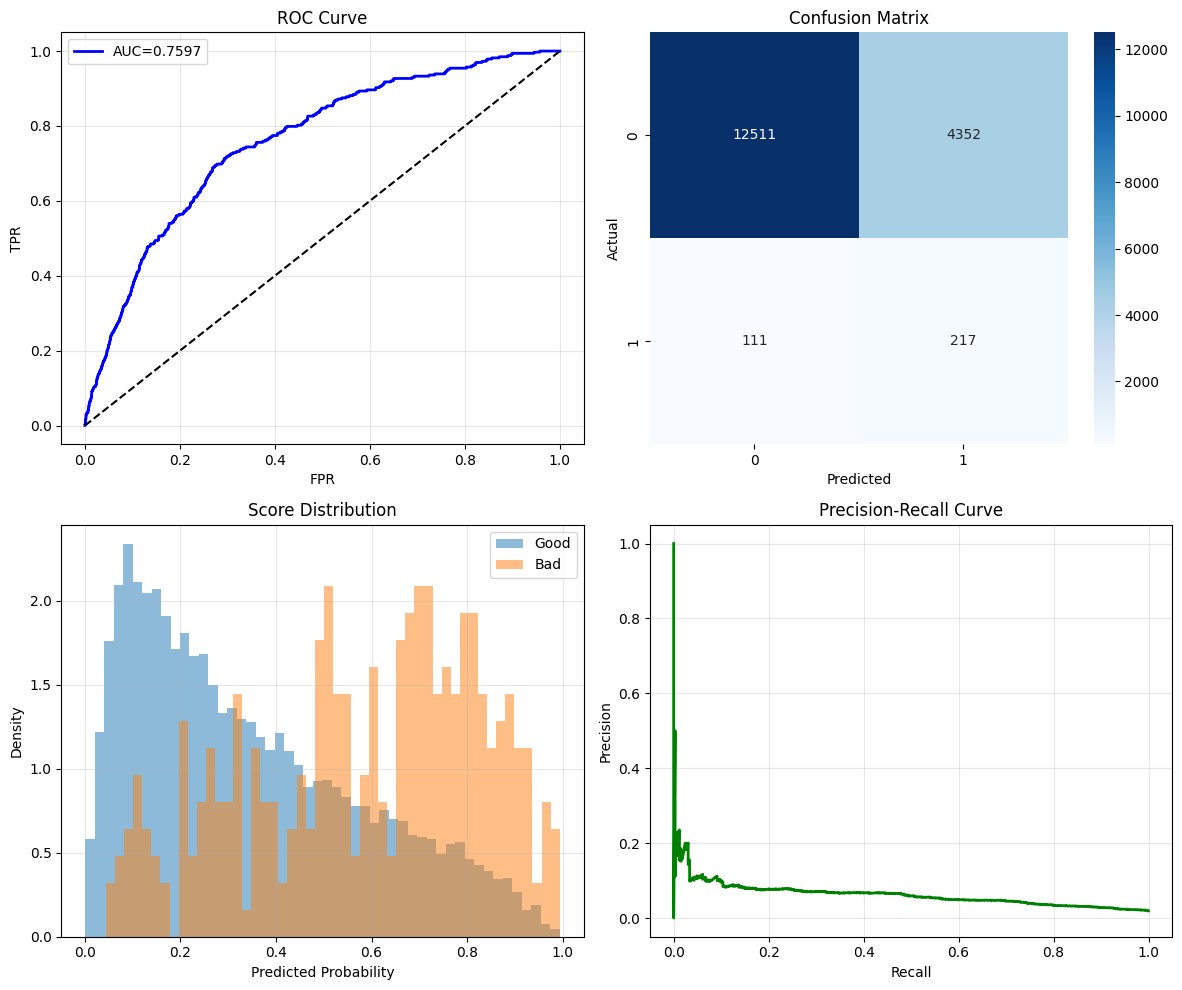

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# ROC Curve
ax = axes[0, 0]
fpr, tpr, _ = roc_curve(y_val, y_val_pred)
ax.plot(fpr, tpr, 'b-', lw=2, label=f'AUC={roc_auc_score(y_val, y_val_pred):.4f}')
ax.plot([0,1], [0,1], 'k--')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
ax.set_title('ROC Curve')
ax.legend()
ax.grid(True, alpha=0.3)

# Confusion Matrix
ax = axes[0, 1]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')

# Score Distribution
ax = axes[1, 0]
ax.hist(y_val_pred[y_val==0], bins=50, alpha=0.5, label='Good', density=True)
ax.hist(y_val_pred[y_val==1], bins=50, alpha=0.5, label='Bad', density=True)
ax.set_xlabel('Predicted Probability')
ax.set_ylabel('Density')
ax.set_title('Score Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Precision-Recall Curve
ax = axes[1, 1]
precision, recall, _ = precision_recall_curve(y_val, y_val_pred)
ax.plot(recall, precision, 'g-', lw=2)
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curve')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/reoptimization_results.png', dpi=150)
plt.show()

In [11]:
# Save model
model_artifacts = {
    'model': model,
    'preprocessor': preprocessor,
    'woe_binner': woe_binner,
    'feature_selector': feature_selector,
    'metrics': {
        'train_auc': roc_auc_score(y_train, y_train_pred),
        'train_gini': gini(y_train, y_train_pred),
        'val_auc': roc_auc_score(y_val, y_val_pred),
        'val_gini': gini(y_val, y_val_pred)
    }
}

with open(f'{OUTPUT_DIR}/credit_scoring_model_reoptimized.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print(f"\nModel saved!")
print(f"Train Gini: {gini(y_train, y_train_pred):.4f}")
print(f"Val Gini:   {gini(y_val, y_val_pred):.4f}")


Model saved!
Train Gini: 0.6496
Val Gini:   0.5195
